In [1]:
import numpy as np # we imported numpy package as np so we will call it np in the future
import matplotlib.pyplot as plt # we import matplotlib.pyplot as plt
from statistics import mean

In [2]:
num_States = 5 # we have 5 states in our state space
num_Actions = 2 # we have 2 actions in our action space

q_Table = np.zeros((num_States, num_Actions)) # we define Q-Table with all zeros in it
print(q_Table) # we print our first tiny Q-Table

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [3]:
envInfo = [[(0,0), (0,1), (0,2), (0,3), (1,1), (1,3), (2,0), (2,1), (2,2), (2,3), (3,1), (3,3), (4,1)], 
           [(1,0), (1,2), (1,4), (2,4), (3,0), (3,2), (4,0), (4,2), (4,3), (4,4)]]
# envInfo[0] => safe path list
# envInfo[1] => cliffs list

In [4]:
class GridWorldEnvironment:
    def __init__(self, info):
        
        self.safePath = info[0] # contains tuples
        self.cliffs = info[1] # contains tuples
        self.startLoc = self.safePath[0] # safe path list's 0th element is start state
        self.trmLoc = self.safePath[11] # safe path list's 9th element is finish state
        self.rewSttTrm = (None, None, None) # (int, int, bool)
    
    def getSttNo(self, loc):
        """
        The method that converts current location to a state number. 
        Returns state number.
        """
        return 4*loc[0]+loc[1]
    
    def envStart(self):

        """The method called when the episode starts, it resets the environment.

        Returns:
        state number.
        """
        reward = 0
        # agentLoc is the current location of the agent
        self.agentLoc = self.startLoc
        # state is state number as an int
        state = self.getSttNo(self.agentLoc)
        termination = False
        self.rewSttTrm = (reward, state, termination)

        return self.rewSttTrm[1]
    
    def envStep(self, action):
        """The method called with every step taken in the environment and updates the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (int, int, bool): a tuple of the reward, state,
                and boolean shows that if it's terminal.
        """
        
        if action == 0: # up         
            possibleNextLoc = (self.agentLoc[0] - 1, self.agentLoc[1])
            if possibleNextLoc[0] >= 0: # check the agent within grid?
                self.agentLoc = possibleNextLoc # if within grid, current location is possible location
            else:
                self.agentLoc = (1,0) # go to a cliff
        elif action == 1: # left
            possibleNextLoc = (self.agentLoc[0], self.agentLoc[1] - 1)
            if possibleNextLoc[1] >= 0: # check the agent within grid?
                self.agentLoc = possibleNextLoc # if within grid, current location is possible location
            else:
                self.agentLoc = (1,0) # go to a cliff
        elif action == 2: # down
            possibleNextLoc = (self.agentLoc[0] + 1, self.agentLoc[1])
            if possibleNextLoc[0] < 4: # check the agent within grid?
                self.agentLoc = possibleNextLoc # if within grid, current location is possible location
            else:
                self.agentLoc = (1,0) # go to a cliff
        elif action == 3: # right
            possibleNextLoc = (self.agentLoc[0], self.agentLoc[1] + 1)
            if possibleNextLoc[1] < 4: # check the agent within grid?
                self.agentLoc = possibleNextLoc # if within grid, current location is possible location
            else:
                self.agentLoc = (1,0) # go to a cliff

        reward = -1 # initiate reward as -1,agent gets a -1 reward for its every step in safe path,so it does not stuck
        terminal = False # holds the termination information
        
        if self.agentLoc == self.trmLoc: # check the terminal is reached?
            reward = 100 # give 100 reward if it terminates the episode
            terminal = True # bool of termination is true
        elif self.agentLoc in self.cliffs: # check fell into cliffs?
            reward = -100 # give -100 reward if it falls into the cliffs
            terminal = False # bool of termination is true
            self.agentLoc = self.startLoc # agent is sent to start state
        else:
            reward = -1 # default value
            terminal = False # default value
        
        self.rewSttTrm = (reward, self.getSttNo(self.agentLoc), terminal) # update rewSttTrm

        return self.rewSttTrm

In [5]:
agentInfo = [4, 25, 0.01, 1, 1, 0] ###numActions, numStates, epsilon, learningRate, discount, random seed

In [6]:
class QLearningAgent:

    def __init__(self, info):
        
        self.numActions = info[0]
        self.numStates = info[1]
        self.epsilon = info[2]
        self.learningRate = info[3]
        self.discount = info[4]
        self.randGenerator = np.random.RandomState(info[5])

        self.qTable = np.zeros((self.numStates, self.numActions)) # The array of action-value estimates.

    def agentStart(self, state):
        
        """The method called when the episode starts, it resets the environment.
        
        Args:
            state (int): the state from the
                environment's evnStart function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        currentQ = self.qTable[state,:] # corresponding row of qTable
        if self.randGenerator.rand() < self.epsilon: # random number generation
            action = self.randGenerator.randint(self.numActions) # take an action randomly
        else:
            action = self.argmax(currentQ) # take an action greedily, the max valued action in currentQ
        self.prevState = state # the trick of TDL
        self.prevAction = action # the trick of TDL
        return action

    def agentStep(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        currentQ = self.qTable[state, :] # corresponding row of qTable
        if self.randGenerator.rand() < self.epsilon:  # random number generation
            action = self.randGenerator.randint(self.numActions) # take an action randomly
        else:
            action = self.argmax(currentQ) # take an action greedily, the max valued action in currentQ
        
        self.qTable[self.prevState,self.prevAction] = self.qTable[self.prevState,self.prevAction] + self.learningRate*(reward + self.discount*max(currentQ) - self.qTable[self.prevState,self.prevAction]) # update qTable
        
        self.prevState = state # the trick of TDL
        self.prevAction = action # the trick of TDL
        return action


    def agentEnd(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        
        self.qTable[self.prevState,self.prevAction] = self.qTable[self.prevState,self.prevAction] + self.learningRate*(reward - self.qTable[self.prevState,self.prevAction])

    def argmax(self, qValues):
        """argmax with random tie-breaking
        Args:
            qValues (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf") # top as negative infinity
        ties = [] # initiate ties

        for i in range(len(qValues)):
            if qValues[i] > top: # element is greater than top
                top = qValues[i] # the element is the new top
                ties = [] # ties resets

            if qValues[i] == top: # if an element is equal to top
                ties.append(i) # we add its index to ties

        return self.randGenerator.choice(ties) # return one of ties randomly
    
    def agentTest(self, state):
        
        # Choose action greedily by exploiting qTable
        currentQ = self.qTable[state,:]
        
        action = self.argmax(currentQ)
        
        return action

In [7]:
env = GridWorldEnvironment(envInfo) # instance of environment
agent = QLearningAgent(agentInfo) # instance of agent
returns = [] # a list that we will append return of every episode
currentReturn = 0 # return of the current episode, we will increment it by rewards

In [8]:
for i in range(30):
    print("Iteration Number: " + str(i))
    currentReturn = 0
    reward = 0
    stt = env.envStart() 
    act = agent.agentStart(stt) # choose action
    rew, stt, trm = env.envStep(act)
    currentReturn += rew
    while(True):
        act = agent.agentStep(rew, stt) # update q table and choose action
        rew, stt, trm = env.envStep(act)
        currentReturn += rew
        if trm: # agent is terminated
            agent.agentEnd(rew) # make a final update to q table
            print("Reward: " + str(rew))
            print("Agent is terminated!")
            ####ask user input for accept the result or not
            answer = input("Do you accept the result? (Yes or No)\n")
            #if yes, the iteration will continue;iF no,the user can input the value to change
            if any(answer.lower() == f for f in ["no", "No", "NO", "n","N"]):
                #Get new reward
                print("Please enter new value of reward: " )#+ str(currentReturn))
                reward = int(input("New value: "))
                #print the new reward value
                currentReturn = rew + reward
                print("New Reward: " + str(currentReturn))
                returns.append(currentReturn) # save the return of the episode
                break
            else:
                print("Reward: " + str(rew))
                print("Agent is terminated!")
            returns.append(currentReturn) # save the return of the episode
            break

Iteration Number: 0
Reward: 100
Agent is terminated!
Do you accept the result? (Yes or No)
n
Please enter new value of reward: 
New value: -2
New Reward: 98
Iteration Number: 1
Reward: 100
Agent is terminated!
Do you accept the result? (Yes or No)
n
Please enter new value of reward: 
New value: -1
New Reward: 99
Iteration Number: 2
Reward: 100
Agent is terminated!
Do you accept the result? (Yes or No)
n
Please enter new value of reward: 
New value: -3
New Reward: 97
Iteration Number: 3
Reward: 100
Agent is terminated!
Do you accept the result? (Yes or No)
n
Please enter new value of reward: 
New value: -2
New Reward: 98
Iteration Number: 4
Reward: 100
Agent is terminated!
Do you accept the result? (Yes or No)
n
Please enter new value of reward: 
New value: -1
New Reward: 99
Iteration Number: 5
Reward: 100
Agent is terminated!
Do you accept the result? (Yes or No)
n
Please enter new value of reward: 
New value: -3
New Reward: 97
Iteration Number: 6
Reward: 100
Agent is terminated!
Do yo

In [9]:
print(agent.qTable)

[[-100. -100. -101.   95.]
 [-101.   -5.   96.   -4.]
 [-102.   -4. -102.   -3.]
 [-103.   -4.   -2. -103.]
 [   0.    0.    0.    0.]
 [  -3. -101.   97. -102.]
 [   0.    0.    0.    0.]
 [  -2. -102.   99. -103.]
 [-103. -103.    0.    0.]
 [  -1.   -1.   -1.   98.]
 [   0.    0. -103.   99.]
 [  -1.    0.  100. -103.]
 [   0.    0.    0.    0.]
 [   0. -102. -104.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]


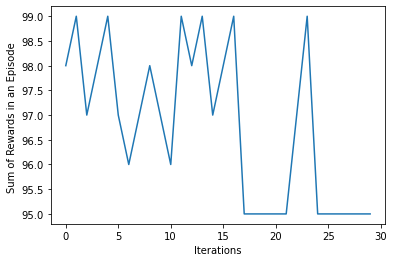

In [18]:
plt.plot((returns))
plt.ylabel('Sum of Rewards in an Episode ')
plt.xlabel('Iterations')
plt.show()

The maximum reward value is: 99


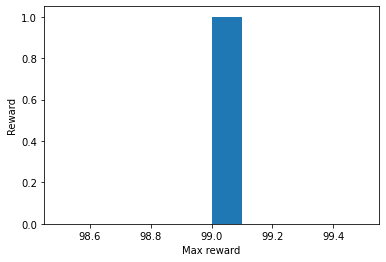

In [19]:
print("The maximum reward value is: " + str(max(returns)))
plt.hist(max(returns))
plt.xlabel('Max reward')
plt.ylabel('Reward');
plt.show()

The average reward value is: 96.76666666666667


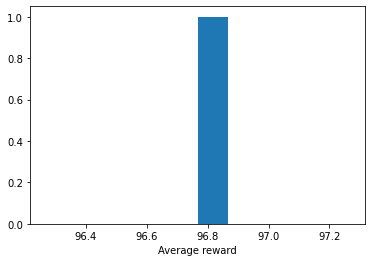

In [20]:
print("The average reward value is: " + str(mean(returns)))
plt.hist(mean(returns))
plt.xlabel('Average reward')
plt.ylabel('');
plt.show()

The minimum reward value is: 95


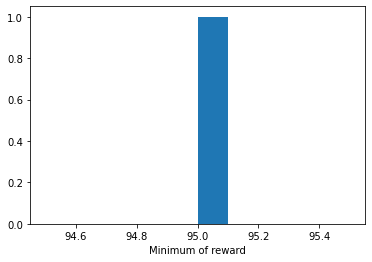

In [21]:
print("The minimum reward value is: " + str(min(returns)))
plt.hist(min(returns))
plt.xlabel('Minimum of reward')
plt.ylabel('');
plt.show()

In [14]:
trainedQTable = agent.qTable

In [15]:
env = GridWorldEnvironment(envInfo)
agent = QLearningAgent(agentInfo)
agent.qTable = trainedQTable # we update the agent's q table as trained q table
chosenPath = [] # we create a list for saving the path
returnOfTestEpisode = 0
stt = env.envStart()
chosenPath.append(stt)
act = agent.agentTest(stt)
rew, stt, trm = env.envStep(act)
chosenPath.append(stt)
returnOfTestEpisode += rew # we increment test episode return by the reward
while(True):
    act = agent.agentTest(stt)
    rew, stt, trm = env.envStep(act)
    chosenPath.append(stt) # we append the state to chosenPath
    returnOfTestEpisode += rew
    if trm:
        print("Agent is terminated!")
        break

Agent is terminated!


In [16]:
print("Test epsiode return: " + str(returnOfTestEpisode))

Test epsiode return: 95


In [17]:
print("Learned path:")

print(chosenPath)

Learned path:
[0, 1, 5, 9, 10, 11, 15]
